In [1]:
import cv2
import glob
import os
from util import *
from Image_registration import registration
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Image_registration.util import filter_and_analyze_matches


In [ ]:
# Rutas de las imágenes
image_0_path = "Cameras/captures/left_thermal_rectified/thermal_20241030_130518.png"
image_1_path = "Cameras/captures/visible/left_rect/LEFT_visible_20241030_130518.png"


In [49]:
image_warped, matches, scores, error = registration.procesar_imagenes(ruta_imagen0=image_0_path, ruta_imagen1=image_1_path, threshold=100, transformation_method="translation_ransac")


Procesando imagenes...
Dispositivo utilizado: cuda
No se aplicará ningún filtro.
No se aplicará ningún filtro.
shape: (480, 640, 3) - Matches: 354 - Score: 354


In [50]:
#El error medio máximo sería alrededor de 800 píxeles para un par de imagenes de 640x480.
error

0

In [51]:
reliable_points, average_score, util_percentage_points = filter_and_analyze_matches(matches, scores, threshold=0.75)

The average score is: 0.5015569925308228

The number of points above a score threshold of 0.75 is: 74

Therefore, for this registration:
20.90% of the points are precise


In [52]:


def show_differences(image_0: np.ndarray, image_1: np.ndarray):
    """
    Fusiona dos imágenes y muestra las diferencias utilizando matplotlib.

    Parámetros:
    - image_0 (np.ndarray): Primera imagen (por ejemplo, una imagen RGB).
    - image_1 (np.ndarray): Segunda imagen (por ejemplo, una imagen en escala de grises).

    La función convierte la segunda imagen a RGB, asegura que ambas imágenes tengan el mismo tamaño,
    las fusiona sumando sus valores de píxeles y muestra la imagen resultante en el notebook.
    """
    # Verificar si image_1 es una imagen en escala de grises (2 dimensiones)
    if len(image_1.shape) == 2:
        # Convertir la imagen en escala de grises a RGB
        image_1_rgb = cv2.cvtColor(image_1, cv2.COLOR_GRAY2RGB)
    elif len(image_1.shape) == 3 and image_1.shape[2] == 1:
        # Si image_1 tiene un solo canal pero en formato 3D, también convertir a RGB
        image_1_rgb = cv2.cvtColor(image_1, cv2.COLOR_GRAY2RGB)
    else:
        # Si image_1 ya tiene 3 canales, asumir que está en BGR y convertir a RGB
        image_1_rgb = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)

    # Verificar si image_0 también está en BGR y convertir a RGB si es necesario
    if len(image_0.shape) == 3 and image_0.shape[2] == 3:
        image_0_rgb = cv2.cvtColor(image_0, cv2.COLOR_BGR2RGB)
    else:
        image_0_rgb = image_0.copy()

    # Asegurarse de que ambas imágenes tengan el mismo tamaño
    if image_0_rgb.shape != image_1_rgb.shape:
        print(f"Las resoluciones no son iguales.\nimage_0: {image_0_rgb.shape}\nimage_1: {image_1_rgb.shape}")
        image_1_rgb = cv2.resize(image_1_rgb, (image_0_rgb.shape[1], image_0_rgb.shape[0]))

    # Fusionar las imágenes sumando sus valores de píxeles
    # Asegurarse de que el tipo de datos sea adecuado para evitar desbordamientos
    merged_image = cv2.add(image_0_rgb.astype(np.uint16), image_1_rgb.astype(np.uint16))
    merged_image = np.clip(merged_image, 0, 255).astype(np.uint8)

    # Mostrar la imagen fusionada usando matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(merged_image)
    plt.title('Registered Differences')
    plt.axis('off')  # Ocultar los ejes para una mejor visualización
    plt.show()
    
    return merged_image


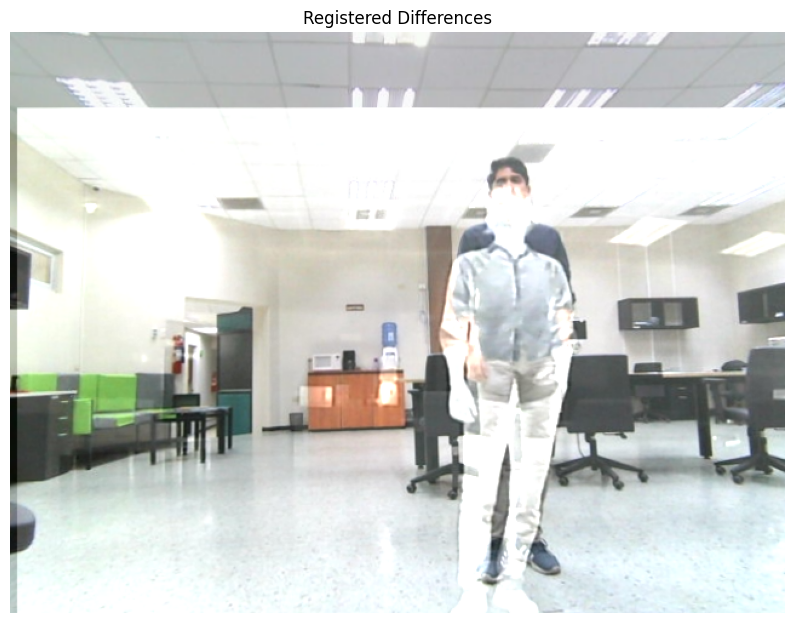

Image saved as '..\tmp\16.png'.


WindowsPath('../tmp/16.png')

In [53]:
# # Fusionar las imágenes y mostrar las diferencias
image_1 = cv2.imread(image_1_path, cv2.IMREAD_COLOR)

image_with_diferences = show_differences(image_1, image_warped)
save_image(image_with_diferences, '../tmp/')

In [9]:
# Rutas de las imágenes

color1_images = glob.glob('Cameras/captures/left_thermal_rectified/*.png')
thermal_images  = glob.glob('Cameras/captures/thermal_rectified/*.png')


In [ ]:
results = []
for id_, (im1, im2) in enumerate(zip(color1_images, thermal_images), start=1):
    image_warped, matches, scores, error = registration.procesar_imagenes(
        ruta_imagen0=im1, 
        ruta_imagen1=im2, 
        threshold=50
    )

    reliable_points, average_score, util_percentage_points = filter_and_analyze_matches(
        matches, 
        scores, 
        threshold=0.75
    )

    # Crear un diccionario para la fila actual
    result = {
        'ID': str(id_),
        'Matches': len(matches),
        'Homography_Error': error,
        'Reliable_Matches': len(reliable_points),
        'Average_Match_Score': average_score,
        'Util_percentage_matches': util_percentage_points
    }

    # Agregar el diccionario a la lista de resultados
    results.append(result)

In [ ]:
df = pd.DataFrame(results)


In [ ]:
df.iloc[:, 1:].agg(['count', 'mean', 'sum', 'min', 'max'])

In [ ]:
df.describe()

In [ ]:
numerical_columns = ['Matches', 'Homography_Error', 'Reliable_Matches', 'Average_Match_Score', 'Util_percentage_matches']
df[numerical_columns] = df[numerical_columns].apply(pd.to_numeric)
df_results = df

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el estilo de Seaborn
sns.set(style='whitegrid')


In [ ]:
columns_to_average = ['Matches','Homography_Error', 'Reliable_Matches', 'Average_Match_Score', 'Util_percentage_matches']
average_values = df_results[columns_to_average].mean()

# Paso 2: Crear el Gráfico de Barras
sns.set(style='whitegrid')

plt.figure(figsize=(8, 6))
sns.barplot(x=average_values.index, y=average_values.values, palette='viridis')

plt.title('Visible Rectificada - Termal Rectificada\nPromedio de Métricas de Registro de Imágenes')
plt.xlabel('Métricas')
plt.ylabel('Valor Promedio')
plt.xticks(rotation=45)

# Mostrar los valores encima de cada barra
for index, value in enumerate(average_values.values):
    plt.text(index, value + max(average_values.values)*0.01, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='ID', y='Homography_Error', marker='o')
plt.title('Error de Homografía por ID de Imagen')
plt.xlabel('ID de Imagen')
plt.ylabel('Error de Homografía')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
df_results_melted = df_results.melt(id_vars='ID', value_vars=['Matches', 'Reliable_Matches'], var_name='Tipo', value_name='Cantidad')
sns.barplot(data=df_results_melted, x='ID', y='Cantidad', hue='Tipo')
plt.title('Visible Rectificada - Termal\n Matches Totales y Confiables')
plt.xlabel('ID de Imagen')
plt.ylabel('Cantidad de Matches')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Match')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x='ID', y='Average_Match_Score', palette='viridis')
plt.title('Score Promedio de Matches')
plt.xlabel('ID de Imagen')
plt.ylabel('Score Promedio de Matches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_results, x='Homography_Error', bins=10, kde=True)
plt.title('Distribución del Error de Homografía')
plt.xlabel('Error de Homografía')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='ID', y='Util_percentage_matches', marker='o', color='green')
plt.title('Porcentaje de Matches Útiles por ID de Imagen')
plt.xlabel('ID de Imagen')
plt.ylabel('Porcentaje de Matches Útiles (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_results,
    x='Reliable_Matches',
    y='Homography_Error',
    hue='Average_Match_Score',
    size='Average_Match_Score',
    palette='RdYlGn',
    sizes=(50, 200)
)
plt.title('Error de Homografía vs. Número de Matches Confiables')
plt.xlabel('Número de Matches Confiables')
plt.ylabel('Error de Homografía')
plt.legend(title='Score Promedio', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()
